# Telecom Customer Churn

# Context

This dataset comes from an Iranian telecom company, with each row representing a customer over a year period. Along with a churn label, there is information on the customers' activity, such as call failures and subscription length. 

# Business Problem

Customer churn is a key metric for many businesses, as keeping as many customers as possible helps keep profits high. Being able to predict whether or not a customer will end their subscription would help a company by allowing them to intervene before it is too late by doing things like sending targeted promotions to the customer. 

In this report we will attempt to provide the company with the means of predicting which customers are in danger of ending their service, and allow them to intervene. 

# Summary

Being able to attract new customers to the business is a difficult, time consuming, and labor intensive task. Also according to Forrester, it costs 5 times more money to attract new customers than to keep existing ones. Once our company attracts customers we do not want to have them leave the service if it can be avoided. In light of this we propose a model which predicts whether or not a customer will leave our service. 

Our modeling begins with creating a logistic regression model using the most important features (a specific type of data such as the frequency of use of SMS) found via RFE. We then used a few techniques to handle the class imbalance (there are a lot more customers who stay rather than churn) of our data, and tune our hyper-parameters. After doing this we select our random forest model as it has the highest recall, which we value most, of any of our models. For future study we suggest gathering far more data and possibly using a nueral network. 

# Load the Data 

In [42]:
%%capture

pip install imblearn

In [43]:
#Data handlers
import pandas as pd
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#ML model neccesities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

#Imbalanced learning 
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTENC

In [44]:
#Read the CSV
df = pd.read_csv('data/customer_churn.csv')

df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### Data Dictionary
| Column                  | Explanation                                             |
|-------------------------|---------------------------------------------------------|
| Call Failure            | number of call failures                                 |
| Complains               | binary (0: No complaint, 1: complaint)                  |
| Subscription Length     | total months of subscription                            |
| Charge Amount           | ordinal attribute (0: lowest amount, 9: highest amount) |
| Seconds of Use          | total seconds of calls                                  |
| Frequency of use        | total number of calls                                   |
| Frequency of SMS        | total number of text messages                           |
| Distinct Called Numbers | total number of distinct phone calls                    |
| Age Group               | ordinal attribute (1: younger age, 5: older age)        |
| Tariff Plan             | binary (1: Pay as you go, 2: contractual)               |
| Status                  | binary (1: active, 2: non-active)                       |
| Age                     | age of customer                                         |
| Customer Value          | the calculated value of customer                        |
| Churn                   | class label (1: churn, 0: non-churn)                    |

# Exploratory Data Analysis

We first want to double check what kind of data types we will be working with, then we will want to see if there are any missing values in the dataset. 

In [45]:
df.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

In [46]:
#Find how many null values are in each column
df.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

We see that there are no missing values, so the data is ready to start analysing.  We begin by identifying which column we want to predict (churn), then by identifying which features are categorical and which are numerical. After this we will split our data into training and testing data so we can look at the distributions of the associated columns. 

In [47]:
#Define the variable we want to predict later
target = ['Churn']

#Categorical variables
cat = ['Complains', 'Charge  Amount', 'Age Group', 'Tariff Plan', 'Status']

#Numerical variables
num = [col for col in df.columns if col not in cat + target + ['Age']]

#Double check numerical is defined correctly
num

['Call  Failure',
 'Subscription  Length',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Customer Value']

In [48]:
#Split into training and testing data

train, test = train_test_split(df, test_size = 0.2, random_state = 0)
train_v, test_v = train_test_split(df, test_size = 0.2, random_state = 0)


train_X = train.drop(columns = 'Churn')
train_y = train['Churn']
test_X = test.drop(columns = 'Churn')
test_y = test['Churn']

train_X_valid = train_v.drop(columns = 'Churn')
train_y_valid = train_v['Churn']
test_X_valid = test_v.drop(columns = 'Churn')                       
test_y_valid = test_v['Churn']



### Numerical Features

We now want to see what the distributions of the columns are to see if there is any skew, or if there are any outliers. 

In [49]:
train_X[num].describe()

,Call Failure,Subscription Length,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Customer Value
count,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000
mean,7.707937,32.477381,4503.731746,69.939683,74.125000,23.751190,476.809431
std,7.248853,8.606679,4200.742669,57.492298,112.322933,17.151787,520.723791
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,1398.750000,27.000000,7.000000,11.000000,114.480000
50%,6.000000,35.000000,3035.000000,54.000000,21.000000,21.000000,230.380000
75%,12.000000,38.000000,6525.750000,95.250000,92.000000,34.000000,795.440000
max,36.000000,46.000000,17090.000000,255.000000,515.000000,97.000000,2149.280000


===Distribution of numerical features (before transforming)===


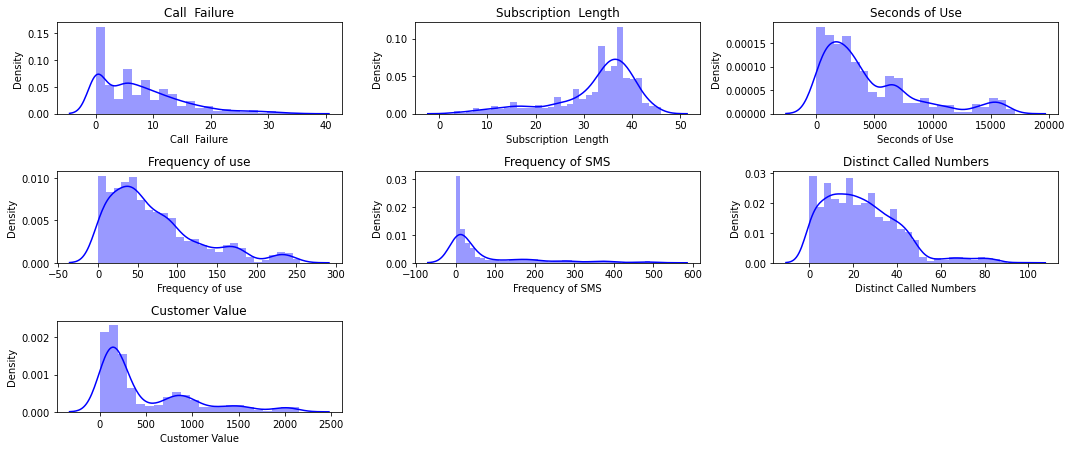

In [50]:
print(f'===Distribution of numerical features (before transforming)===')

plt.figure(figsize = (15,8))

for i, col in enumerate(num):
    plt.subplot(4,3,i+1); sns.distplot(train_X[col], color = 'Blue')
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

We see that all of the columns are skewed which will create problems in future machine learning efforts as normality is an assumption for most models. Hence, we will preform a log transform to counter this. 

In [51]:
#Define the function log_transform, to_log is a list of columns to transform
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Add 1 to the data to prevent infinite values (log(0) = inf)
        X[item] = np.log(1+X[item])
    return X

In [52]:
train_X_l = log_transform(train_X, num)
test_X_l = log_transform(test_X, num)
train_X_val_l = log_transform(train_X_valid, num)
test_X_val_l = log_transform(test_X_valid, num)

train_X_l[num].describe()

,Call Failure,Subscription Length,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Customer Value
count,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000
mean,1.709622,3.459712,7.657922,3.792196,2.996275,2.868971,5.387292
std,1.072790,0.364229,1.957904,1.211578,1.884202,0.983819,1.598641
min,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.693147,3.401197,7.244048,3.332205,2.079442,2.484907,4.749097
50%,1.945910,3.583519,8.018296,4.007333,3.091042,3.091042,5.444060
75%,2.564949,3.663562,8.783664,4.566939,4.532599,3.555348,6.680152
max,3.610918,3.850148,9.746307,5.545177,6.246107,4.584967,7.673353


Now that all the numerical features are transformed, let's take a look at their distributions to see if skew has been reduced. 

===Distribution of numerical features (after transforming)===


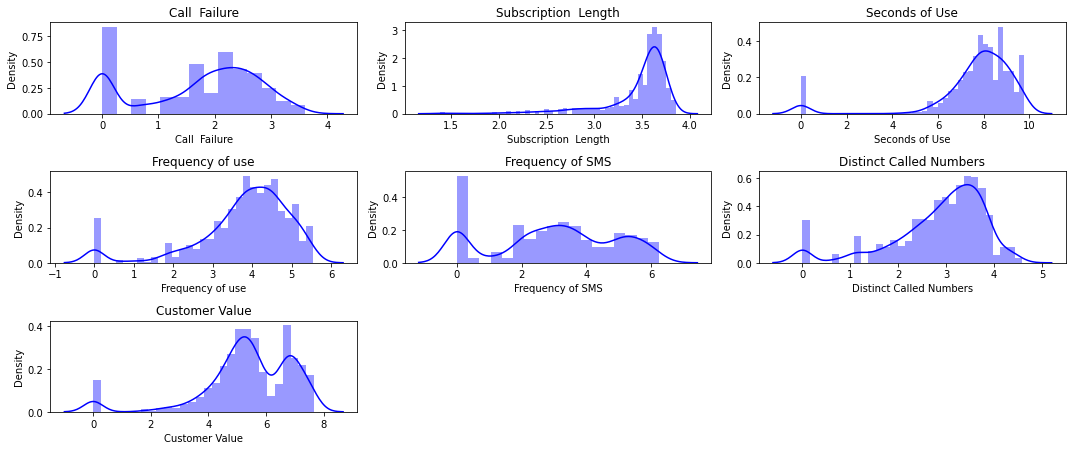

In [53]:
print(f'===Distribution of numerical features (after transforming)===')

plt.figure(figsize = (15,8))

for i, col in enumerate(num):
    plt.subplot(4,3,i+1); sns.distplot(train_X_l[col], color = 'Blue')
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

It seems that some of the skew was taken care of, but not all of it. We will continue ahead, but keep note of this in our analysis. Now we will scale all of our data to have mean 0 and standard deviation 1 as this will ensure that all of the numerical features are affecting our models according to how influential they actually are, and not based on the size of their values.

In [54]:
#Instantiate the scaler
scaler = StandardScaler()

#Fit the transformed training data
scaler.fit(train_X_l)

tmp_train = scaler.transform(train_X_l)
tmp_test = scaler.transform(test_X_l)
tmp_valid = scaler.transform(test_X_val_l)

#Create dataframes with centered data
train_X_cen = pd.DataFrame(data = tmp_train, index = train_X.index, columns = train_X.columns)
test_X_cen = pd.DataFrame(data = tmp_test, index = test_X.index, columns = test_X.columns)
valid_X_cen = pd.DataFrame(data = tmp_valid, index = test_X.index, columns = train_X.columns)

train_X_cen.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
count,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03,2.520000e+03
mean,-9.727668e-17,6.132661e-17,8.205077e-16,-4.652363e-17,4.511382e-17,1.311121e-16,2.379049e-16,1.092600e-17,-1.867994e-16,2.960595e-16,-5.780209e-17,7.753939e-17,2.044220e-17
std,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00,1.000198e+00
min,-1.593939e+00,-2.855610e-01,-5.693748e+00,-6.233525e-01,-3.912063e+00,-3.130586e+00,-1.590525e+00,-2.916736e+00,-2.060822e+00,-2.959954e-01,-5.675743e-01,-1.824433e+00,-3.370588e+00
25%,-9.476941e-01,-2.855610e-01,-1.606847e-01,-6.233525e-01,-2.114286e-01,-3.797382e-01,-4.866865e-01,-3.904582e-01,-9.328308e-01,-2.959954e-01,-5.675743e-01,-6.844451e-01,-3.992898e-01
50%,2.202998e-01,-2.855610e-01,3.399830e-01,-6.233525e-01,1.840975e-01,1.776034e-01,5.030576e-02,2.257691e-01,1.951604e-01,-2.959954e-01,-5.675743e-01,-1.144512e-01,3.551739e-02
75%,7.974513e-01,-2.855610e-01,5.597858e-01,2.791130e-02,5.750872e-01,6.395769e-01,8.155334e-01,6.978049e-01,1.951604e-01,-2.959954e-01,-5.675743e-01,-1.144512e-01,8.088847e-01
max,1.772644e+00,3.501879e+00,1.072164e+00,5.889285e+00,1.066855e+00,1.447146e+00,1.725121e+00,1.744566e+00,2.451143e+00,3.378431e+00,1.761884e+00,2.735518e+00,1.430287e+00


In [55]:
train_X_cen.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
2859,0.641701,-0.285561,0.339983,0.027911,0.420336,0.527204,-1.222579,0.433973,0.195160,-0.295995,-0.567574,-0.114451,-0.052173
793,-1.593939,-0.285561,-1.140139,-0.623352,0.215107,0.192478,-1.590525,0.270961,0.195160,-0.295995,-0.567574,-0.114451,-0.314690
2875,-0.093405,-0.285561,0.016543,-0.623352,0.202279,-0.542129,-1.590525,-0.097987,0.195160,-0.295995,-0.567574,-0.114451,-0.336455
2034,-0.947694,-0.285561,0.101044,0.679175,0.585488,0.757291,1.371386,0.606701,-0.932831,3.378431,-0.567574,-0.684445,1.202313
493,0.220300,-0.285561,-0.553650,0.679175,0.302247,0.399947,0.214947,0.807820,0.195160,-0.295995,-0.567574,-0.114451,0.138641


Now everything has mean 0 and std 1 as desired. We will now look to our categorical features. 

### Categorical Features

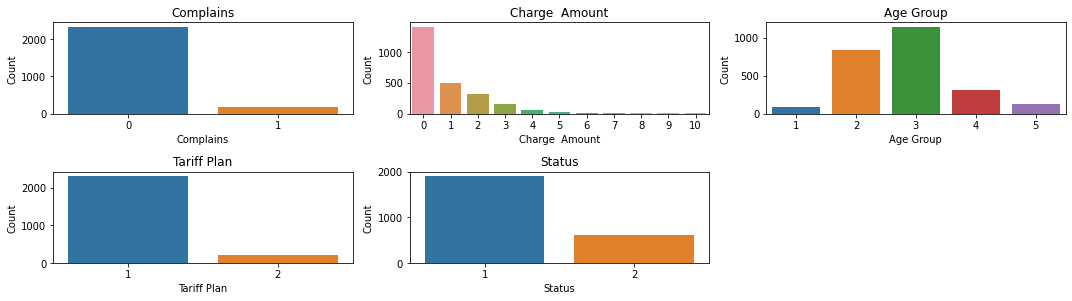

In [56]:
# Check distribution (non-num)
plt.figure(figsize=(15, 8))
# Plot distribution 
for i, col in enumerate(cat):
    order = train[col].value_counts().index   
    plt.subplot(4,3,i+1); sns.countplot(data = train_X, x = train_X[col], order = None )
    
    #plt.subplot(1,1,i+1); sns.countplot(train[col],palette=cmap, order = order ) 
    plt.title(f'{col}')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
# Show the plot
plt.tight_layout()
plt.show()



It appears that most users do not complain, most users are middle aged, most pay as they go (as opposed to contractual), and most are active users of the serivice. 

### Target



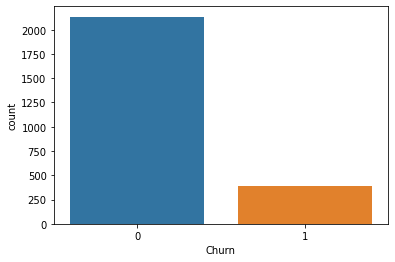

In [57]:
sns.countplot(data = train, x = 'Churn')
plt.show()

We see that there is a large class imbalance, so we will need to note that while building our models. To that end we will apply things such as re-sampling techniques. Now we will look at the distribution of our features given whether or not they churned. 

In [58]:
train['churn'] = np.where(train['Churn'] == 1, 'yes', 'no')

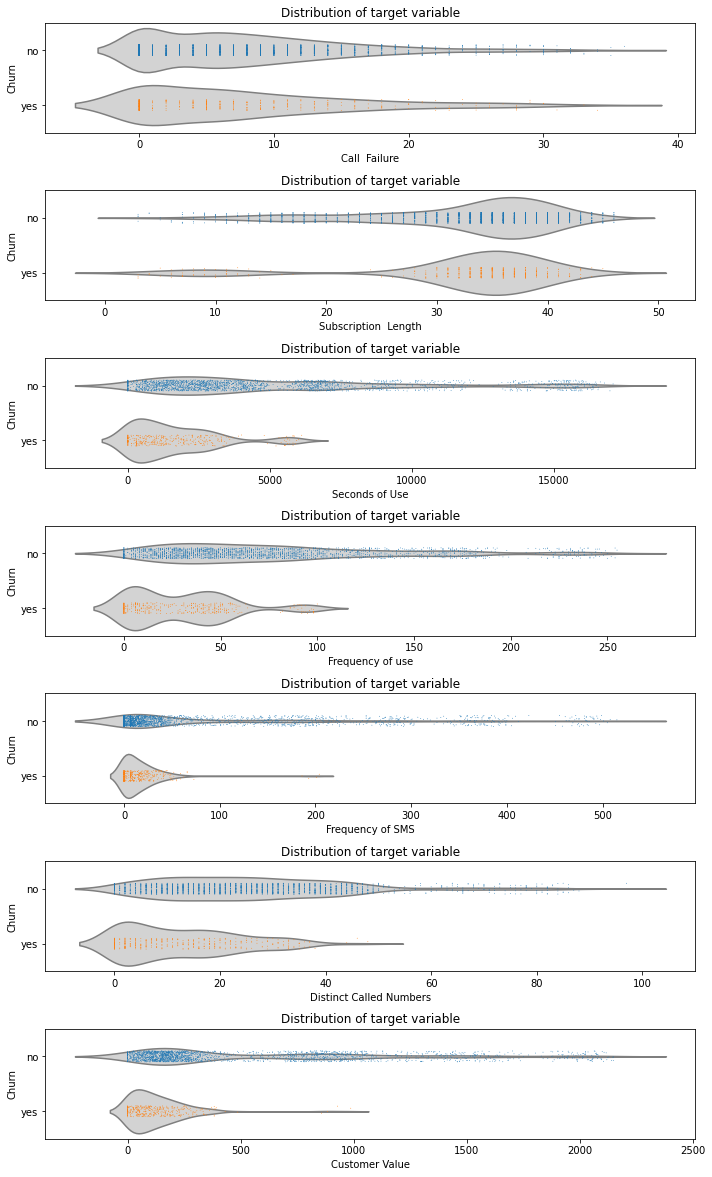

In [59]:
plt.figure(figsize=(10, 30))
# Plot distribution of numerical columns
for i, col in enumerate(num):
    plt.subplot(13,1,1+i); sns.violinplot(x=col, y='churn', data=train, inner=None, color='lightgray');sns.stripplot(x=col, y='churn', data=train, size=0.8,jitter=True);
    plt.title('Distribution of target variable');
    plt.ylabel('Churn')
    # Show the plot
plt.tight_layout()
plt.show()

We can see that variables associated with frequency of use lead to two very different distributions amoung churned vs not churned customers. We see that customers that churn are using the service far less than customers who do not churn. Moreover, customer value tends to be larger among those who do not churn.

As we move on, we argue that recall is the most important metric for consideration, as we want to correctly identify those customers who will end their subscription. If the company incorrectly provides promotions for customers who were not going to leave, there will only be a bit of money lost, but the customer will likely be happier with the service and unlikely to leave if they incounter future problems with the service. Moreover, there is a chance that using the service more makes customers less likely to churn; although we cannot directly conclude that from the data as it could be that customers who will stay with the service tend to use it more.

# Feature Selection

As there is a large class imbalance we will upsample the churned customers.

In [60]:
#Function that upsamples data
def up_data(X, y):
    #Concat into one dataframe
    data = pd.concat([X, y], axis=1)
    #Seperate into two dataframes for each target value
    churn = data[data['Churn']==1]
    not_churn = data[data['Churn']==0]
    # Upsample minority and combine with majority
    data_upsampled = resample(churn, replace=True, n_samples=len(not_churn), random_state=42)
    upsampled = pd.concat([not_churn, data_upsampled])
    # Upsampled feature and target
    X_up = upsampled.drop('Churn', axis=1)
    y_up = upsampled[['Churn']]
    #X_up.head()
    
    return X_up, y_up

In [61]:
train_X_cen_up, train_y_up = up_data(train_X_cen, train_y)
test_X_cen_up, test_y_up = up_data(test_X_cen, test_y)
valid_X_cen_up, valid_y_up = up_data(valid_X_cen, test_y_valid)

valid_X_cen_up.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
1185,-1.593939,-0.285561,0.101044,-0.623352,0.234985,0.422566,-1.590525,0.355731,-0.932831,-0.295995,-0.567574,-0.684445,-0.214456
683,1.512790,-0.285561,0.016543,1.330439,1.041581,1.393867,-0.368234,1.587849,-0.932831,-0.295995,-0.567574,-0.684445,0.799179
305,0.220300,-0.285561,0.101044,-0.623352,0.259082,0.411334,-0.056217,0.270961,-0.932831,-0.295995,-0.567574,-0.684445,0.055568
1716,-1.593939,-0.285561,0.339983,-0.623352,-0.522749,-1.229724,-1.007344,-0.309083,-0.932831,-0.295995,1.761884,-0.684445,-0.994445
1505,0.641701,-0.285561,0.415222,0.679175,0.333955,0.556173,0.453265,0.883162,0.195160,-0.295995,-0.567574,-0.114451,0.296672


### PCA

We will attempt to use principal component analysis to both reduce the number of features, and thereby reducing model complexity, and remove multi-collinearity (which reduces statistical significance of our independent variables).

In [62]:
n = 12
columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12']

In [63]:
pca = PCA(n_components = n)

#Fit to imbalanced data as pca is unsurpervised
pc = pca.fit_transform(train_X_cen)

df_pc = pd.DataFrame(pc, columns=columns, index = train_X_cen.index) 

#df_pc.head()
#df_pc.head()
pca.explained_variance_ratio_

array([0.36865608, 0.16537431, 0.10191724, 0.09178849, 0.07547704,
       0.06896468, 0.04388392, 0.03800793, 0.02242276, 0.01423817,
       0.00391311, 0.00306604])

In [64]:
df_PCA = pd.concat([df_pc, train_y], axis=1)
df_PCA.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,Churn
2859,-0.555451,0.162804,-0.298623,-0.690226,-0.538774,1.269980,0.063056,-0.195787,-0.466531,0.196367,0.173107,0.279707,0
793,0.787143,-0.332327,1.299482,-0.968436,0.736957,1.505417,0.976079,-0.450661,0.324254,-0.094680,0.022559,0.344197,0
2875,0.795064,-0.079284,0.239255,-0.779146,-0.239362,1.189290,0.360963,-0.143726,-0.537091,0.338554,0.758311,0.133588,0
2034,-2.254136,-1.387405,1.406595,2.118070,-0.679034,-1.239349,1.792594,-0.527393,0.325082,-0.062902,-0.228796,-0.122474,0
493,-1.069290,0.258486,0.462350,-0.164873,0.104357,0.500663,-0.412182,0.201098,0.300756,-0.494746,-0.003402,0.142577,0


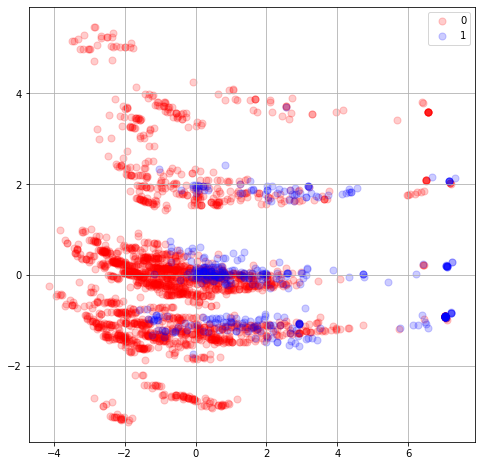

In [65]:
targets = [0, 1]
colors = ['red', 'blue']

fig, ax = plt.subplots(figsize=(8,8))


# For loop to create plot
for target, color in zip(targets,colors):
    indicesToKeep = df_PCA['Churn'] == target
    ax.scatter(df_PCA.loc[indicesToKeep, 'PCA_1']
               , df_PCA.loc[indicesToKeep, 'PCA_2']
               , c = color
               , s = 50
              , alpha =0.2)

# Legend    
ax.legend(targets)
ax.grid()
plt.show()

We see that there are distinct clusters between our two target values. Larger values for the largest principle components correspond to churned customers (blue) whereas smaller values correspond to non-churned customers (red). Also, more extreme values for the second principle component correspond to non-churned customers.

Now we will see how many principle components it takes to explain a reasonable amount of variance as this will guide us in feature selection for our models. 

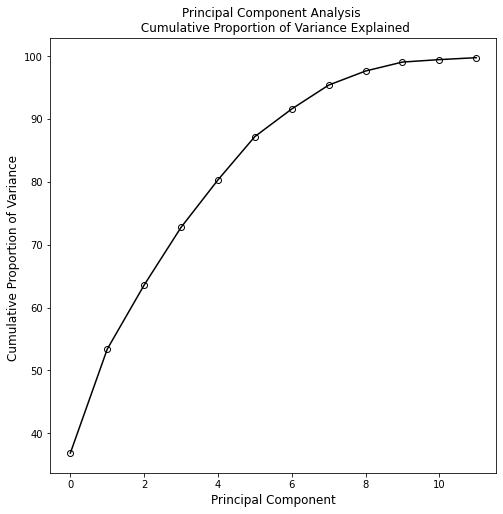

In [66]:
plt.figure(figsize=(8, 8))

# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.show()

We see that it takes around 5 principle components to achive a 90% explanation of the variance. We will note this for later use during feature selection. 

### Hyperparameter Tuning

In [67]:
# Function to find lowest C and plot the result
def lowest_err(model, C_values, train_errs, valid_errs):
    
    # Print lowest valid err 
    C_values_df = pd.DataFrame(C_values)
    valid_errs_df = pd.DataFrame(valid_errs)
    min_err = min(valid_errs_df[0])
    min_idx = valid_errs_df[0].idxmin(axis = 1)
    min_C = C_values_df.loc[min_idx, 0]
    print(f'Min validation error ({model})  occur at C={round(min_C, 5)} and error = {round(min_err,5)}')

    # Plot results
    plt.figure(figsize=(8,5))
    plt.semilogx(C_values, train_errs, C_values, valid_errs)
    plt.annotate(f'Min error occur at Hyper-param ={round(min_C, 3)} and error = {round(min_err,3)}', xy=(min_C, min_err),fontsize=12,arrowprops=dict(facecolor='green', shrink=0.25),)
    plt.legend(("train", "validation"))
    plt.title(model)
    plt.xlabel('Hyper-parameter')
    plt.ylabel('Error')
    plt.show()
    
    # Return
    return {'Model':model, 'Best hyperparam': min_C}

In [68]:

m_C = list()

train_errs = list()
valid_errs = list()

c_vals = np.logspace(-5, 8, 15)

for c_value in c_vals:
    # Create LogisticRegression object and fit
    clf = LogisticRegression(C=c_value)
    clf.fit(train_X_cen_up, train_y_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(train_X_cen_up, train_y_up) )
    valid_errs.append( 1.0 - clf.score(valid_X_cen_up, valid_y_up) )


Min validation error (Logistic regression)  occur at C=0.05179 and error = 0.12284


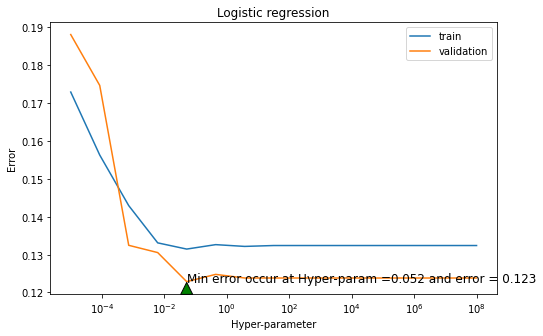

In [69]:
m_C.append( lowest_err('Logistic regression', c_vals, train_errs, valid_errs) )

In [70]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()
c_vals = [int(x) for x in np.linspace(1, 900, 15)]

# Loop over values of C_value
for c_value in c_vals:
    # Create LogisticRegression object and fit
    clf = GradientBoostingClassifier(n_estimators=c_value)
    clf.fit(train_X_cen_up, train_y_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(train_X_cen_up, train_y_up) )
    valid_errs.append( 1.0 - clf.score(valid_X_cen_up, valid_y_up) )

Min validation error (Gradient Boosting)  occur at C=193 and error = 0.06718


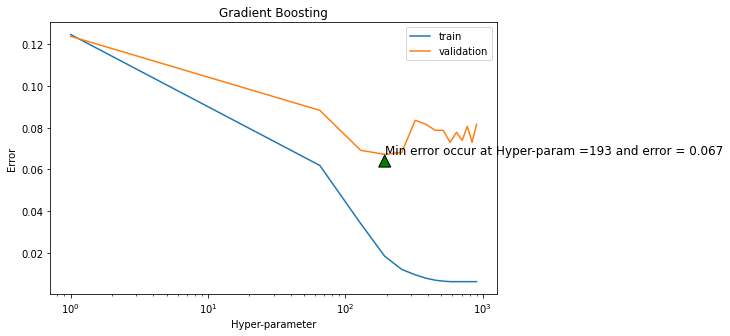

In [71]:
m_C.append(lowest_err('Gradient Boosting', c_vals, train_errs, valid_errs))

In [72]:
train_errs = list()
valid_errs = list()
c_vals = [int(x) for x in np.linspace(1, 900, 15)]

# Loop over values of C_value
for c_value in c_vals:
    # Create LogisticRegression object and fit
    clf = RandomForestClassifier(n_estimators=c_value,random_state=0)
    clf.fit(train_X_cen_up, train_y_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(train_X_cen_up, train_y_up) )
    valid_errs.append( 1.0 - clf.score(valid_X_cen_up, valid_y_up) )

Min validation error (Random Forest)  occur at C=386 and error = 0.0691


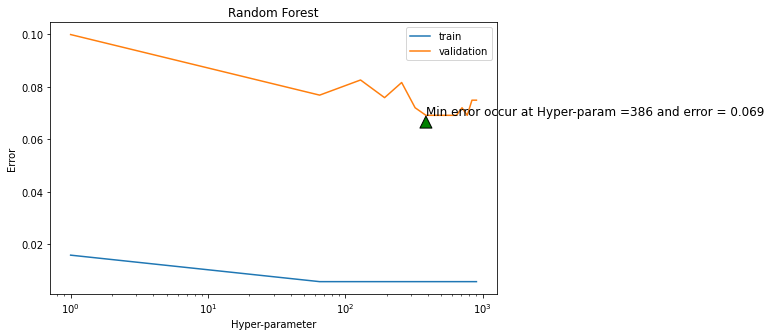

In [73]:
m_C.append(lowest_err('Random Forest', c_vals, train_errs, valid_errs))

In [74]:
# Print min C
m_C = pd.DataFrame(m_C)
m_C.set_index('Model', inplace=True)
m_C

,Best hyperparam
Model,
Logistic regression,0.051795
Gradient Boosting,193.000000
Random Forest,386.000000


We see each hyperparameter that minimizes error for each model above. 

In [75]:
train_valid_X_cen_up = pd.concat([train_X_cen_up, valid_X_cen_up], axis=0)
train_valid_X_cen_up.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
2859,0.641701,-0.285561,0.339983,0.027911,0.420336,0.527204,-1.222579,0.433973,0.195160,-0.295995,-0.567574,-0.114451,-0.052173
793,-1.593939,-0.285561,-1.140139,-0.623352,0.215107,0.192478,-1.590525,0.270961,0.195160,-0.295995,-0.567574,-0.114451,-0.314690
2875,-0.093405,-0.285561,0.016543,-0.623352,0.202279,-0.542129,-1.590525,-0.097987,0.195160,-0.295995,-0.567574,-0.114451,-0.336455
2034,-0.947694,-0.285561,0.101044,0.679175,0.585488,0.757291,1.371386,0.606701,-0.932831,3.378431,-0.567574,-0.684445,1.202313
493,0.220300,-0.285561,-0.553650,0.679175,0.302247,0.399947,0.214947,0.807820,0.195160,-0.295995,-0.567574,-0.114451,0.138641


### RFE

We will now use RFE to identify which features are of importance for each model. Using the guidance from our PCA step we will look for around 5 features for each model, and have each model vote for those to decide the most important features among all of our models. 

In [76]:
train_valid_y_up = pd.concat([train_y_up, valid_y_up], axis=0)
train_valid_y_up.tail()

,Churn
628,1
349,1
668,1
1374,1
727,1


In [77]:
n_features_select = 5

step = 1

In [78]:
# RFE for Log Reg
rfe_lg = RFE(estimator=LogisticRegression(C=m_C.loc['Logistic regression', 'Best hyperparam']), 
             n_features_to_select=n_features_select, step=step, verbose=1)
rfe_lg.fit(train_valid_X_cen_up, train_valid_y_up)
# Calculate the score on the test set
#score = rfe_lg.score(X_test_e_l_n, y_test)
score = rfe_lg.score(test_X_cen_up, test_y_up)
print('Logistic regression can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
lg_mask = rfe_lg.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Logistic regression can explain 87.0% of the variance in the test set


In [79]:
# RFE for GB
rfe_gb = RFE(estimator=GradientBoostingClassifier(n_estimators = int(m_C.loc['Gradient Boosting', 'Best hyperparam'])), 
             n_features_to_select=n_features_select, step=step, verbose=1)
rfe_gb.fit(train_valid_X_cen_up, train_valid_y_up)
# Calculate the score on the test set
#score = rfe_lg.score(X_test_e_l_n, y_test)
score = rfe_gb.score(test_X_cen_up, test_y_up)
print('Gradient Boosting can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
gb_mask = rfe_gb.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Gradient Boosting can explain 95.2% of the variance in the test set


In [80]:
#RFE for RF
rfe_rf = RFE(estimator=RandomForestClassifier(n_estimators = int(m_C.loc['Random Forest', 'Best hyperparam'])), 
             n_features_to_select=n_features_select, step=step, verbose=1)
rfe_rf.fit(train_valid_X_cen_up, train_valid_y_up)
# Calculate the score on the test set
#score = rfe_lg.score(X_test_e_l_n, y_test)
score = rfe_rf.score(test_X_cen_up, test_y_up)
print('Random Forest can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
rf_mask = rfe_rf.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Random Forest can explain 98.8% of the variance in the test set


In [81]:
#Sum the votes of the three models
votes = np.sum([lg_mask, rf_mask, gb_mask], axis=0)
# Create a mask for features selected by all 3 models
meta_mask = votes >= 2
print('The following features are selected by at least 2 models:')
train_valid_X_cen_up.loc[:, meta_mask].columns

The following features are selected by at least 2 models:


Index(['Complains', 'Seconds of Use', 'Frequency of use', 'Status',
       'Customer Value'],
      dtype='object')

We see that all three models see the same 5 features as being the most important. 

In [82]:
train_X_mask = train_valid_X_cen_up.loc[:, meta_mask]
test_X_mask = test_X_cen.loc[:, meta_mask]
train_X_mask.head()

,Complains,Seconds of Use,Frequency of use,Status,Customer Value
2859,-0.285561,0.420336,0.527204,-0.567574,-0.052173
793,-0.285561,0.215107,0.192478,-0.567574,-0.314690
2875,-0.285561,0.202279,-0.542129,-0.567574,-0.336455
2034,-0.285561,0.585488,0.757291,-0.567574,1.202313
493,-0.285561,0.302247,0.399947,-0.567574,0.138641


Now that we have determined the most important features we will fit our models to only those features. 

In [83]:
rf = RandomForestClassifier(n_estimators=int(m_C.loc['Random Forest', 'Best hyperparam']), random_state=0)
rf.fit(train_X_mask, train_valid_y_up)
score = rf.score(test_X_mask, test_y)
print('Random forest (dimension reduced) can explain {0:.1%} of the variance in the test set.'.format(score))
# Predict labels of test data
pred_y = rf.predict(test_X_mask)
# Cnfusion matrix and classification report
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

Random forest (dimension reduced) can explain 98.1% of the variance in the test set.
[[509  12]
 [  0 109]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       521
           1       0.90      1.00      0.95       109

    accuracy                           0.98       630
   macro avg       0.95      0.99      0.97       630
weighted avg       0.98      0.98      0.98       630



In [84]:
gb = GradientBoostingClassifier(n_estimators=int(m_C.loc['Gradient Boosting', 'Best hyperparam']), random_state=0)
gb.fit(train_X_mask, train_valid_y_up)
score = gb.score(test_X_mask, test_y)
print('Gradient (dimension reduced) can explain {0:.1%} of the variance in the test set.'.format(score))
# Predict labels of test data
pred_y = gb.predict(test_X_mask)
# Cnfusion matrix and classification report
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

Gradient (dimension reduced) can explain 93.8% of the variance in the test set.
[[487  34]
 [  5 104]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       521
           1       0.75      0.95      0.84       109

    accuracy                           0.94       630
   macro avg       0.87      0.94      0.90       630
weighted avg       0.95      0.94      0.94       630



We will see how much importance each feature carries for the models.

In [85]:
col_names = test_X_mask.columns
model_rank = list()
def model_impt(model, label):
    tmp = dict()
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    #print(importances)
    # Print the feature ranking
    print(f"Feature ranking ({label}):")
    tmp['Model'] = label
    for f in range(len(indices)):
        print("%d. %s (%f)" % (f + 1, col_names[indices[f]], importances[indices[f]]))
        tmp[col_names[indices[f]]] = importances[indices[f]]
    print (' ')
    return tmp

In [86]:
# Random forest
model_rank.append( model_impt(rf, 'Random forest'))
# Gradient boosting
model_rank.append( model_impt(gb, 'Gradient boosting'))

Feature ranking (Random forest):
1. Customer Value (0.239096)
2. Status (0.219175)
3. Seconds of Use (0.205195)
4. Frequency of use (0.199163)
5. Complains (0.137372)
 
Feature ranking (Gradient boosting):
1. Status (0.421652)
2. Complains (0.204517)
3. Seconds of Use (0.142526)
4. Frequency of use (0.124221)
5. Customer Value (0.107084)
 


Having the importance listed, lets see if there is any multi-colinearity in our feature space. 

<AxesSubplot:>

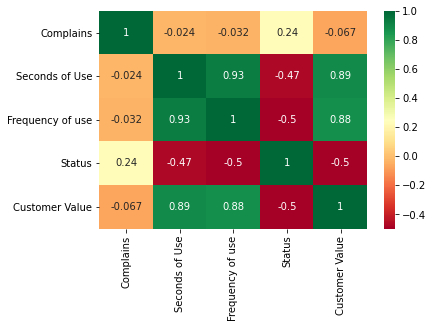

In [87]:
sns.heatmap(train_X_mask.corr(), annot = True, cmap = 'RdYlGn')

We see that we exhibit multicolinearity among seconds of use, frequency of use, and customer value. We will drop the two columns, frequency of use and seconds of use as a result of the feature ranking above. 

<AxesSubplot:>

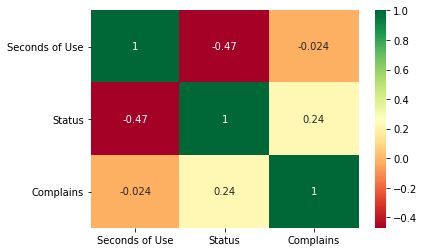

In [88]:
columns = ['Seconds of Use', 'Status', 'Complains']

train_X_mask = train_X_mask[columns] 
test_X_mask = test_X_mask[columns]

sns.heatmap(train_X_mask.corr(), annot=True, cmap='RdYlGn')

Now we will fit our models using only these three features. 

In [89]:
rf = RandomForestClassifier(n_estimators=int(m_C.loc['Random Forest', 'Best hyperparam']), random_state=0)
rf.fit(train_X_mask, train_valid_y_up)
score = rf.score(test_X_mask, test_y)
print('Random forest (dimension reduced even more) can explain {0:.1%} of the variance in the test set.'.format(score))
# Predict labels of test data
pred_y = rf.predict(test_X_mask)
# Cnfusion matrix and classification report
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

Random forest (dimension reduced even more) can explain 95.1% of the variance in the test set.
[[493  28]
 [  3 106]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       521
           1       0.79      0.97      0.87       109

    accuracy                           0.95       630
   macro avg       0.89      0.96      0.92       630
weighted avg       0.96      0.95      0.95       630



In [90]:
gb = GradientBoostingClassifier(n_estimators=int(m_C.loc['Gradient Boosting', 'Best hyperparam']), random_state=0)
gb.fit(train_X_mask, train_valid_y_up)
score = gb.score(test_X_mask, test_y)
print('Gradient (dimension reduced even more) can explain {0:.1%} of the variance in the test set.'.format(score))
# Predict labels of test data
pred_y = gb.predict(test_X_mask)
# Cnfusion matrix and classification report
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

Gradient (dimension reduced even more) can explain 87.3% of the variance in the test set.
[[447  74]
 [  6 103]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       521
           1       0.58      0.94      0.72       109

    accuracy                           0.87       630
   macro avg       0.78      0.90      0.82       630
weighted avg       0.92      0.87      0.88       630



# Final Models

We now will go through our final modeling steps. We will use a few different techniques for dealing with the challenges this dataset imposes. How we do this will be detailed below. 

In [91]:
final_result = list()
# Define list to store result 
final_model = list()
def model_run(model, clf, X=test_X, y=test_y):

    # Evaluate error rates and append to lists
    y_test_predict = clf.predict(X)
    auc = roc_auc_score(y, y_test_predict)
    precision =precision_score(y, y_test_predict)
    recall = recall_score(y, y_test_predict)
    accuracy = clf.score(X, y)

    # Print classification report
    print(f'== {model} - Classification report ==')
    print(classification_report(y, y_test_predict))
    
    # Plot confusion matrix
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_test_predict)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'{model}- Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')   
    plt.show()
    
    # Plot ROC curve
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X)[:,1]
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds= roc_curve(test_y, y_pred_prob)
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.plot(fpr, tpr, marker='.', label=model)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model} - ROC curve')
    plt.annotate(f'AUC ={round(auc, 5)} ', xy=(0.7, 0.5),fontsize=12,)
    # show the legend
    plt.legend()    
    plt.show()
    
    precision_, recall_, _ = precision_recall_curve(test_y, y_pred_prob)
    # Random classifier is one which randomly predicts a class and is the ratio of the ones in the dataset
    random_clf = test_y[test_y==1].count() / len(test_y) #len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [random_clf, random_clf], linestyle='--', label='Average precision')
    plt.plot(recall_, precision_, marker='.', label=model)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model} - Precision recall curve')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    return {'Model':model, \
            'Accuracy': round(accuracy,5) , \
            'Precision':round(precision,5) , \
            'Recall':round(recall,5), \
            'AUC':round(auc,5)}
    

In [92]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
def best_param_search(model, pipe, new_params, kf):
    # Run search for best param

    clf = GridSearchCV(pipe, param_grid=new_params, cv=kf, scoring='roc_auc',
                            return_train_score=True)
    # Fit to model with best hyper-param
    clf.fit(train_X_cen, train_y)
    # Print best results
    clf.cv_results_['mean_test_score'], clf.cv_results_['mean_train_score']
    # Best score 
    clf.best_score_
    # Best param
    clf.best_params_
    # Print test result
    test_predict_y = clf.best_estimator_.predict(test_X_cen)
    score = roc_auc_score(test_y, test_predict_y)
    
    # Print all stats
    # final_model.append(model_run(model, clf, X=X_test, y=y_test))

    #return clf.best_params_, score 
    return clf, {'Model':model, 'Best hyperparam': clf.best_params_, 'AUC':round(score,5)}
    #return {'Model':model, 'AUC':round(score,5)}

Note that randomized search would likely be optimal if we acquire more data later on as we have a relatively low dimensional feature space, and randomized search is much less computationally expensive. 

### Out of the Box Logistic Regression

== Logistic regression - Classification report ==
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       521
           1       0.74      0.56      0.64       109

    accuracy                           0.89       630
   macro avg       0.83      0.76      0.79       630
weighted avg       0.88      0.89      0.88       630



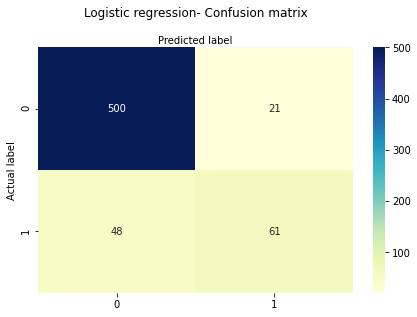

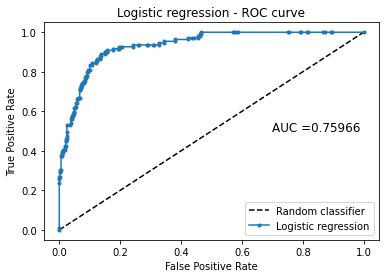

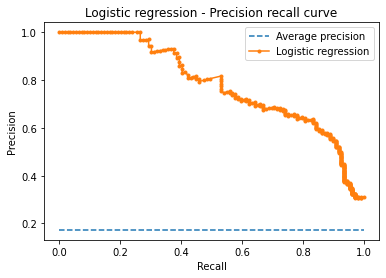

In [93]:
clf = LogisticRegression()
clf.fit(train_X_cen, train_y)
final_model.append(model_run('Logistic regression', clf, X=test_X_cen, y=test_y))
#== Logistic regression (feature

### Improved Logistic Regression

We apply SMOTENC, k-fold cv, and pipelining for more sound results.

== Logistic Regression (improved) - Classification report ==
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       521
           1       0.55      0.89      0.68       109

    accuracy                           0.86       630
   macro avg       0.76      0.87      0.79       630
weighted avg       0.90      0.86      0.87       630



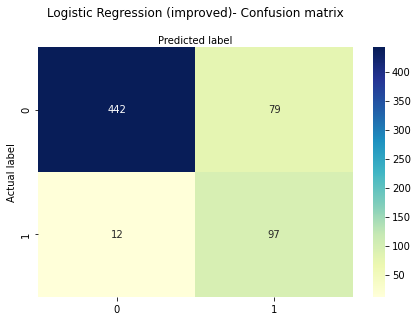

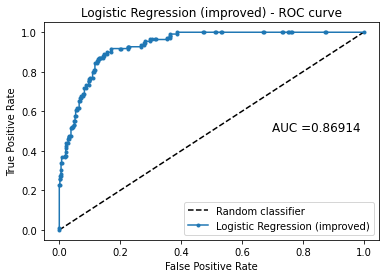

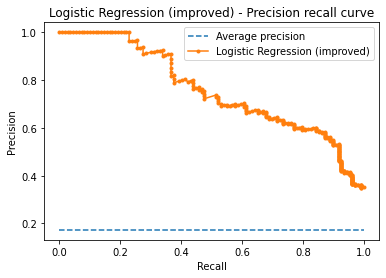

[{'Model': 'Logistic regression',
  'Accuracy': 0.89048,
  'Precision': 0.7439,
  'Recall': 0.55963,
  'AUC': 0.75966},
 {'Model': 'Logistic Regression (improved)',
  'Accuracy': 0.93263,
  'Precision': 0.55114,
  'Recall': 0.88991,
  'AUC': 0.86914}]

In [94]:
penalty = ['l1','l2','elasticnet','none']
c_values = np.logspace(-7, 1, 10)
# Define params
params = {
    'penalty': penalty,
    'C': c_values,
    'random_state': [0]
}
new_params = {'logisticregression__' + key: params[key] for key in params}

# Create pipeline
pipe = make_pipeline(SMOTENC(categorical_features = [1,3,9,10], random_state=42), 
                              LogisticRegression(penalty='l1' ,C=0, random_state=0))
# Search for best param
lr_clf, lr = best_param_search('Logistic Regression (improved)', pipe, new_params,kf)
# Print result
final_model.append(model_run('Logistic Regression (improved)', lr_clf, X=test_X_cen, y=test_y))
# Append result
final_result.append(lr)
final_result
final_model

### Random Forest

We once again use grid search to find the best parameters, SMOTENC to deal with class imbalance, and a stratified k-fold cross validation to prevent data leakage. In the future I once again suggest using random search, especially for this model as it is very expensive even with a small amount of data. 

== Random forest (improved) - Classification report ==
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       521
           1       0.75      0.94      0.83       109

    accuracy                           0.93       630
   macro avg       0.87      0.94      0.90       630
weighted avg       0.95      0.93      0.94       630



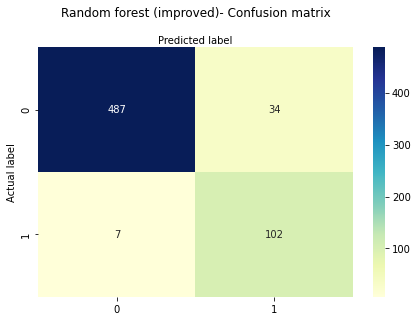

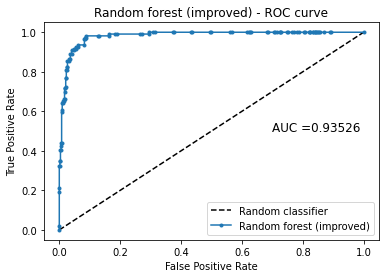

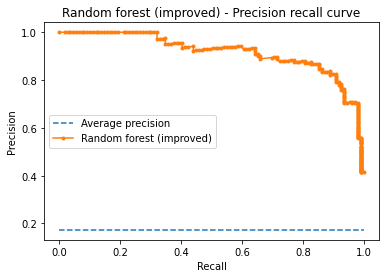

[{'Model': 'Logistic regression',
  'Accuracy': 0.89048,
  'Precision': 0.7439,
  'Recall': 0.55963,
  'AUC': 0.75966},
 {'Model': 'Logistic Regression (improved)',
  'Accuracy': 0.93263,
  'Precision': 0.55114,
  'Recall': 0.88991,
  'AUC': 0.86914},
 {'Model': 'Random forest (improved)',
  'Accuracy': 0.9819,
  'Precision': 0.75,
  'Recall': 0.93578,
  'AUC': 0.93526}]

In [95]:
n_estimators = np.linspace(600,800, num=10)
# Define rf params
params = {
    'n_estimators': [int(x) for x in n_estimators],
    'max_depth': [2, 5, 10],
    'random_state': [0]
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
# Create pipeline
pipe = make_pipeline(SMOTENC(categorical_features = [1,3,9,10], random_state=42), 
                              RandomForestClassifier(n_estimators=386, random_state=0))
# Search for best param
rf_clf, rf = best_param_search('Random forest (improved)', pipe, new_params,kf)
# Print result
final_model.append(model_run('Random forest (improved)', rf_clf, X=test_X_cen, y=test_y))

# Append result
final_result.append(rf)
final_result
final_model

In [96]:
final_model_df = pd.DataFrame(final_model)
final_model_df.set_index('Model', inplace=True)

final_model_df

,Accuracy,Precision,Recall,AUC
Model,,,,
Logistic regression,0.89048,0.74390,0.55963,0.75966
Logistic Regression (improved),0.93263,0.55114,0.88991,0.86914
Random forest (improved),0.98190,0.75000,0.93578,0.93526


Not only is our random forest model the best for recall, but it is the best for all of our metrics. Thus, we will choose it as our final model. 

# Conclusions

We found that the most important features for predicting whether a customer leaves or not are the customer's frequency of use, whether they are active or not, and if they have complained or not. Independent of the modelling results we suggest that the company target those customers with preventive measures.

After careful modeling we were able to produce a model with 93% recall which is the metric we value -fothe most in this scenario. To ensure that are results were sound we applied various techniques such as SMOTENC for dealing with class imbalances and both stratified kfold cross-validiation and pipelines to prevent data leakage. 